In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import scipy.stats as stats
from skpp import ProjectionPursuitRegressor

In [5]:
import os
curr_path = os.getcwd()
citibike_path = os.path.join(curr_path, "citibike_day.csv")
weather_path = os.path.join(curr_path, "nyc_Weather_2013_2023.csv")

In [6]:
# Load data
citibike_df = pd.read_csv(citibike_path)
weather_df = pd.read_csv(citibike_path)

In [7]:
# Display basic information
citibike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      365 non-null    int64  
 1   date            365 non-null    object 
 2   num_trips       365 non-null    int64  
 3   avg_duration    365 non-null    float64
 4   total_duration  365 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 14.4+ KB


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        4017 non-null   object 
 1   temperature_2m_max          4017 non-null   float64
 2   temperature_2m_min          4017 non-null   float64
 3   apparent_temperature_max    4017 non-null   float64
 4   apparent_temperature_min    4017 non-null   float64
 5   precipitation_sum           4017 non-null   float64
 6   rain_sum                    4017 non-null   float64
 7   snowfall_sum                4017 non-null   float64
 8   precipitation_hours         4017 non-null   float64
 9   sunshine_duration           4017 non-null   float64
 10  windspeed_10m_max           4017 non-null   float64
 11  windgusts_10m_max           4017 non-null   float64
 12  winddirection_10m_dominant  4017 non-null   int64  
 13  shortwave_radiation_sum     4017 

In [5]:
# Compute average daily temperature
weather_df['temperature_avg'] = (weather_df['temperature_2m_max'] + weather_df['temperature_2m_min']) / 2

In [9]:
# Rename 'time' to 'date' and convert to datetime
weather_df = weather_df.rename(columns={'time': 'date'})
weather_df['date'] = pd.to_datetime(weather_df['date'])
citibike_df['date'] = pd.to_datetime(citibike_df['date'])

In [7]:
# Select and rename relevant columns
weather_selected = weather_df[[
    'date',
    'temperature_avg',
    'precipitation_sum',
    'windspeed_10m_max',
    'sunshine_duration'
]]

In [10]:
# Merge with Citi Bike data
merged_df = pd.merge(citibike_df, weather_selected, on='date', how='inner').dropna()

In [11]:
# Display first few rows of the merged dataset
merged_df.head()

,Unnamed: 0,date,num_trips,avg_duration,total_duration,temperature_avg,precipitation_sum,windspeed_10m_max,sunshine_duration
0,0,2015-01-01,5317,801.806658,4263206,-1.00,0.0,21.3,29236.59
1,1,2015-01-02,11304,731.240977,8265948,1.45,0.0,19.9,29150.96
2,2,2015-01-03,4478,655.284279,2934363,1.75,16.5,15.8,6444.89
3,3,2015-01-04,7849,679.554211,5333821,10.00,7.2,22.3,0.00
4,4,2015-01-05,14506,637.811802,9252098,1.55,0.0,26.8,29161.29


# Regression Analysis

In [12]:
# Define response and predictors
X = merged_df[['temperature_avg', 'precipitation_sum', 'windspeed_10m_max', 'sunshine_duration']]
y = merged_df['num_trips']

In [14]:
# Add constant to predictors
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

In [15]:
# Show regression summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_trips   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     197.9
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.59e-89
Time:                        15:47:10   Log-Likelihood:                -3775.7
No. Observations:                 365   AIC:                             7561.
Df Residuals:                     360   BIC:                             7581.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.186e+04   1778.374     12.290      0.000    1.84e+04    2.54e+04
temperature_avg     950.7864     42.906     22.160      0.000     866.409    1035.164
precipitation_sum  -554.2002     72.091     -7.688      0.000    -695.972    -412.428
windspeed_10m_max  -266.0749     81.373     -3.270      0.001    -426.102    -106.048
sunshine_duration    -0.0039      0.034     -0.114      0.909      -0.070       0.062
==============================================================================
Omnibus:                       13.958   Durbin-Watson:                   0.629
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.860
Skew:                           0.494   Prob(JB):                     0.000593
Kurtosis:                       2.989   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Visualization

In [17]:
# Predict values using the fitted model
merged_df['predicted_trips'] = model.predict(X)

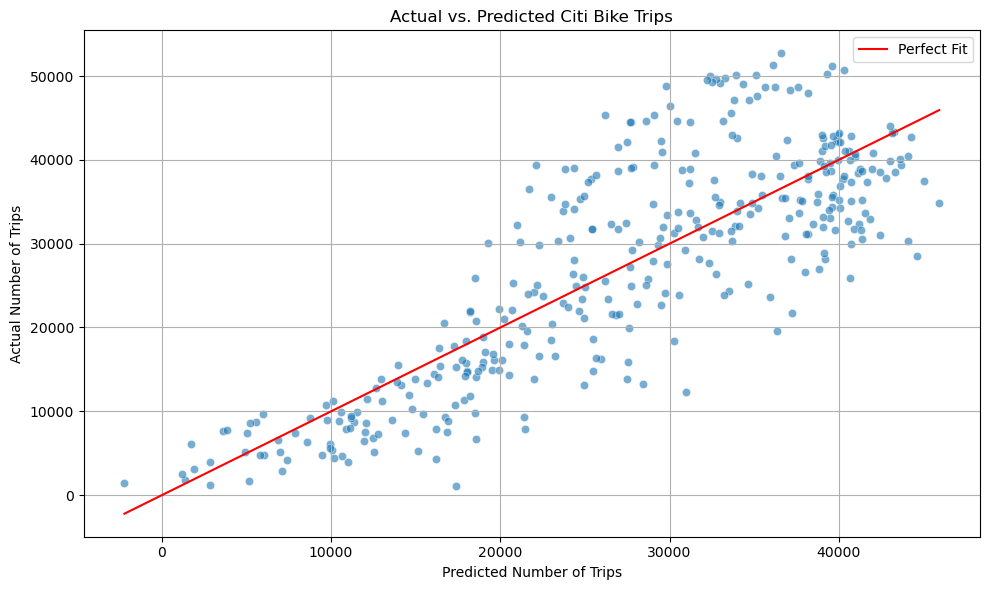

In [18]:
# Create a new DataFrame just for plotting
plot_df = merged_df[['num_trips', 'predicted_trips']].copy()

# Plot actual vs. predicted values with a perfect fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='predicted_trips', y='num_trips', alpha=0.6)
sns.lineplot(data=plot_df.sort_values('predicted_trips'), x='predicted_trips', y='predicted_trips', color='red', label='Perfect Fit')
plt.title('Actual vs. Predicted Citi Bike Trips')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Actual Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Calculate residuals
merged_df['residuals'] = merged_df['num_trips'] - merged_df['predicted_trips']

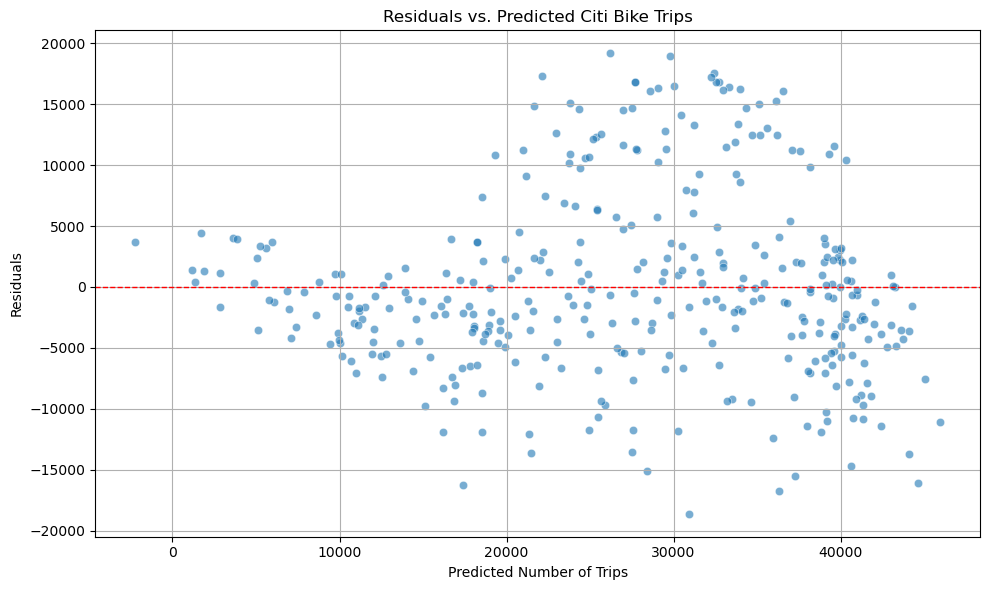

In [20]:
# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_trips', y='residuals', data=merged_df, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted Citi Bike Trips')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

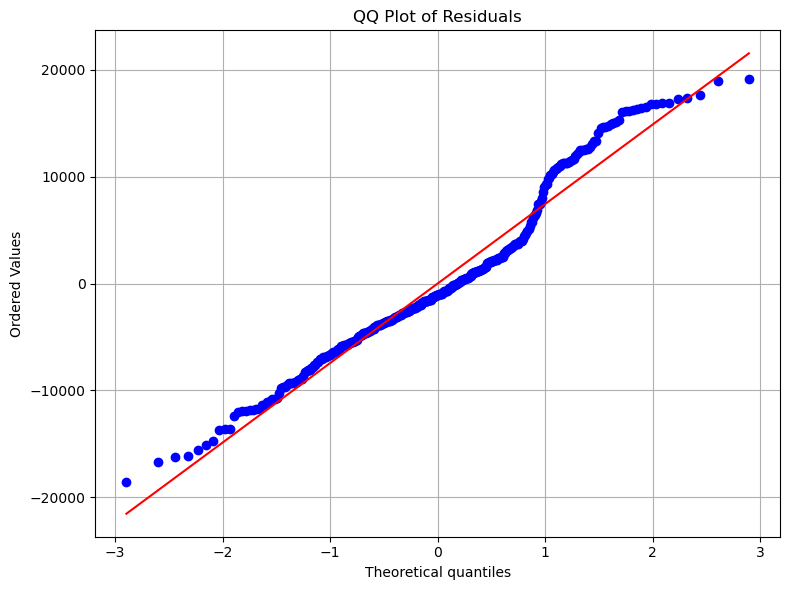

In [23]:
# Generate QQ plot of residuals
plt.figure(figsize=(8, 6))
stats.probplot(merged_df['residuals'], dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Log-transforming

In [24]:
# Add log-transformed features
merged_df['log_num_trips'] = np.log1p(merged_df['num_trips'])  # log(1 + trips)
merged_df['log_temperature_avg'] = np.log1p(merged_df['temperature_avg'] - merged_df['temperature_avg'].min() + 1)
merged_df['log_precipitation_sum'] = np.log1p(merged_df['precipitation_sum'])
merged_df['log_windspeed_10m_max'] = np.log1p(merged_df['windspeed_10m_max'])
merged_df['log_sunshine_duration'] = np.log1p(merged_df['sunshine_duration'])

In [25]:
# Define new model predictors and response
X_log = merged_df[['log_temperature_avg', 'log_precipitation_sum', 'log_windspeed_10m_max', 'log_sunshine_duration']]
y_log = merged_df['log_num_trips']
X_log = sm.add_constant(X_log)

# Fit the log-transformed model
model_log = sm.OLS(y_log, X_log).fit()

# Show summary of the log-transformed model
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_num_trips   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     248.5
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          3.63e-102
Time:                        15:52:35   Log-Likelihood:                -162.49
No. Observations:                 365   AIC:                             335.0
Df Residuals:                     360   BIC:                             354.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.7365      0.272     24.805      0.000       6.202       7.271
log_temperature_avg       1.0576      0.039     27.011      0.000       0.981       1.135
log_precipitation_sum    -0.1957      0.024     -8.024      0.000      -0.244      -0.148
log_windspeed_10m_max    -0.1194      0.072     -1.666      0.097      -0.260       0.022
log_sunshine_duration     0.0330      0.009      3.794      0.000       0.016       0.050
==============================================================================
Omnibus:                      137.200   Durbin-Watson:                   1.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1162.070
Skew:                          -1.334   Prob(JB):                    4.57e-253
Kurtosis:                      11.324   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualization

In [27]:
# Predict log(num_trips) and back-transform to original scale
merged_df['log_predicted_trips'] = model_log.predict(X_log)
merged_df['backtransformed_predicted_trips'] = np.expm1(merged_df['log_predicted_trips'])

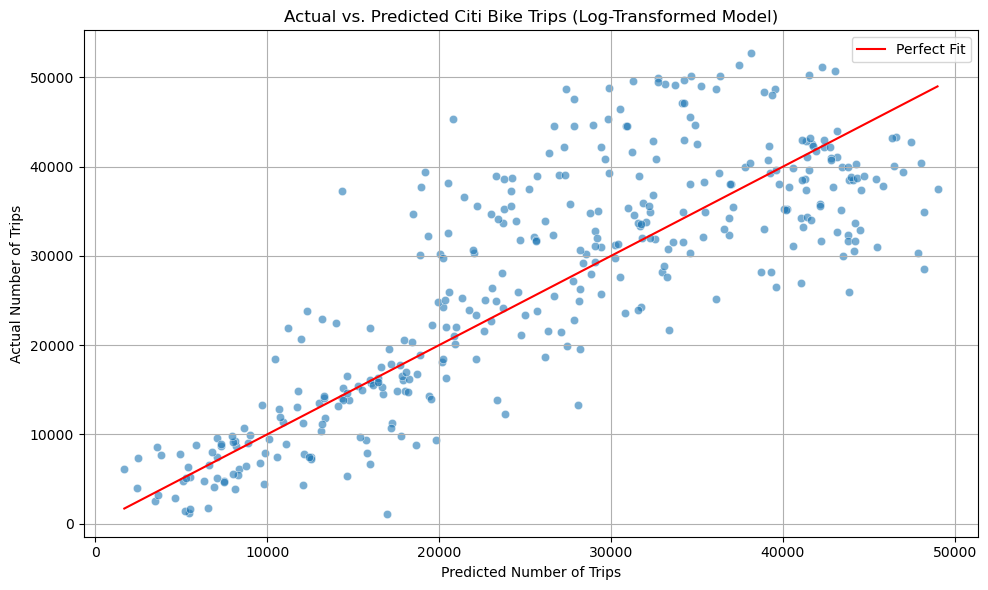

In [28]:
# Plot actual vs. predicted (original scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='backtransformed_predicted_trips',
    y='num_trips',
    data=merged_df,
    alpha=0.6
)
sns.lineplot(
    x='backtransformed_predicted_trips',
    y='backtransformed_predicted_trips',
    data=merged_df.sort_values('backtransformed_predicted_trips'),
    color='red',
    label='Perfect Fit'
)
plt.title('Actual vs. Predicted Citi Bike Trips (Log-Transformed Model)')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Actual Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Calculate residuals in log scale
merged_df['log_residuals'] = merged_df['log_num_trips'] - merged_df['log_predicted_trips']

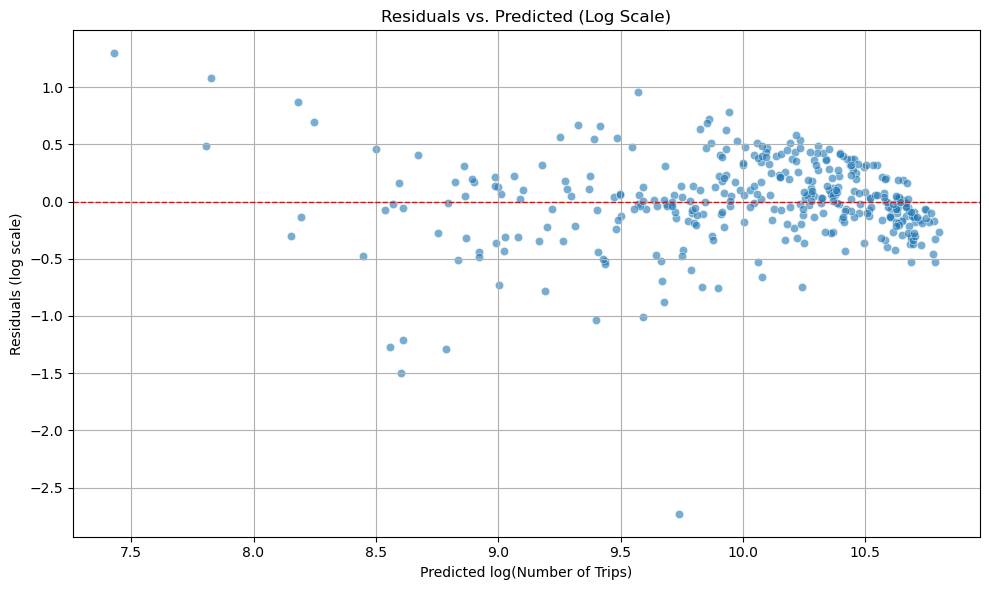

In [30]:
# Residual plot: log residuals vs. predicted (log scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log_predicted_trips',
    y='log_residuals',
    data=merged_df,
    alpha=0.6
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted log(Number of Trips)')
plt.ylabel('Residuals (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

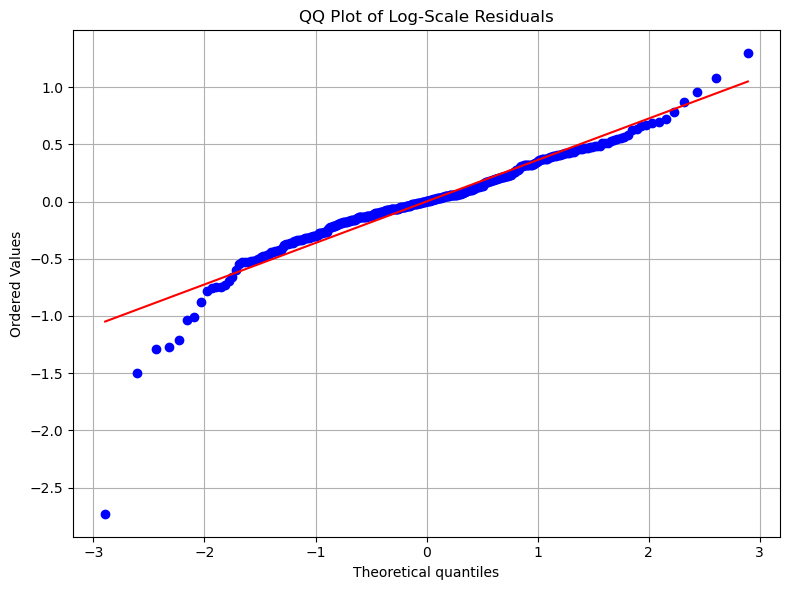

In [31]:
# QQ plot for log residuals
plt.figure(figsize=(8, 6))
stats.probplot(merged_df['log_residuals'], dist="norm", plot=plt)
plt.title('QQ Plot of Log-Scale Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()